In [1]:
from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
import numpy as np

import vis_sim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
phi = np.linspace(0, 2*np.pi, 360, endpoint=False)
theta = np.linspace(0, np.pi/2, 91)
P, T = np.meshgrid(phi, theta)

# linearly polarized source with I = Q and U = V = 0. The source is at theta > 5 deg.
T_MAX_DEG = 5
T_MAX = np.deg2rad(T_MAX_DEG)  # theta max of spherical cap
cap_T = T[T <= T_MAX]
cap_P = P[T <= T_MAX]

dOmega = np.sin(cap_T) * (theta[1] - theta[0]) * (phi[1] - phi[0])

npix = cap_T.size
I = np.ones(npix)
Q = -np.cos(2*cap_P)
U = np.sin(2*cap_P)

kwargs = {"theta": theta, "phi": phi, "dOmega": dOmega}
RM = 100 * I

In [3]:
# sectrometer response
spec4 = np.loadtxt("data/zoom_response_4tap.txt")
spec8 = np.loadtxt("data/zoom_response_8tap.txt")
offset = spec4[:, 0] * 1e3  # spacing in Hz

# normalize response
zoom4 = spec4[:, 1:] / spec4[:, 1:].sum(axis=0, keepdims=True)
zoom8 = spec8[:, 1:] / spec8[:, 1:].sum(axis=0, keepdims=True)

fmin = 30e6  # start frequency
diff = 25e3  # nominal bin width (25 kHz)
nchans = 64  # subchannels to divide chan to
freqs = fmin + offset  # 
chans = np.linspace(0, diff, nchans) + fmin

## Short Dipole

In [4]:
E_theta = -np.cos(T) * np.cos(P)
E_phi = np.sin(P)

short_X = np.array([E_theta, E_phi])
short_Y = np.roll(short_X, 90, axis=-1)

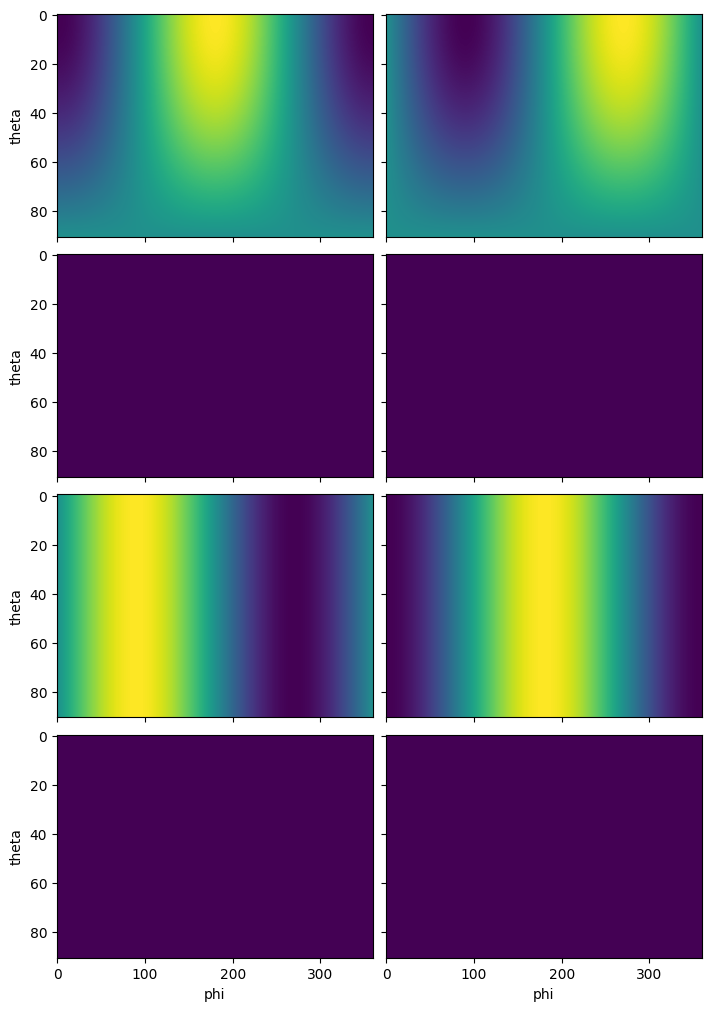

In [5]:
beam1 = np.array([E_theta, E_phi])
beam2 = np.roll(beam1, 90, axis=-1)

fig, axs = plt.subplots(figsize=(7, 10), nrows=4, ncols=2, sharex=True, sharey=True, layout="constrained")
for i in range(2):
    b1 = beam1[i]
    b2 = beam2[i]
    axs[2*i, 0].imshow(b1.real, aspect="auto")
    axs[2*i, 1].imshow(b2.real, aspect="auto")
    axs[2*i+1, 0].imshow(b1.imag, aspect="auto")
    axs[2*i+1, 1].imshow(b2.imag, aspect="auto")
plt.setp(axs[:, 0], ylabel="theta")
plt.setp(axs[-1], xlabel="phi")
plt.show()

# only need beam where src is != 0
beam1 = beam1[:, T <= T_MAX]
beam2 = beam2[:, T <= T_MAX]
beam = np.array([beam1, beam2])

### Zoomed-in region (400 Hz bins)

In [6]:
USE_SPEC = True
sim = vis_sim.Simulator(freqs, I, Q, U, RM, beam, spec=zoom4[:, 1:], **kwargs)
vis4 = sim.vis(faraday=False, use_spec=USE_SPEC)
vis4_rot = sim.vis(faraday=True, use_spec=USE_SPEC)

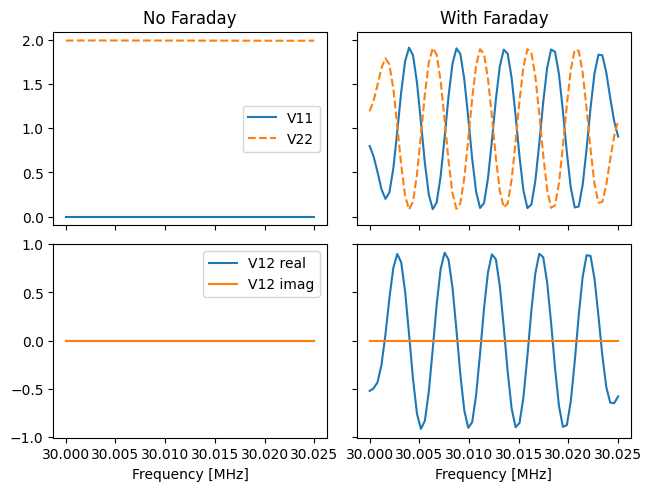

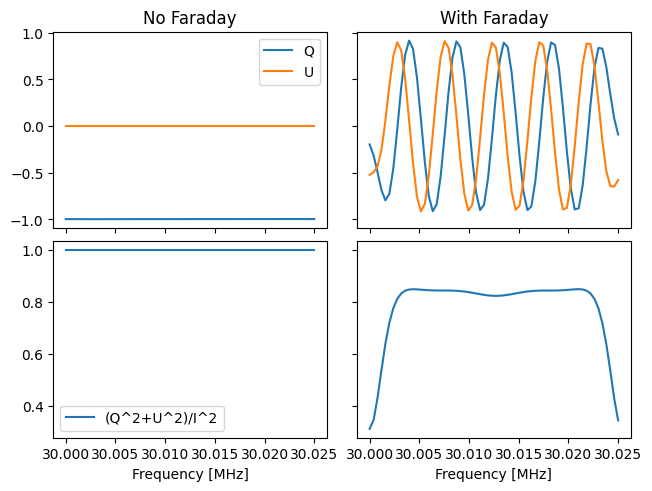

In [7]:
if not USE_SPEC:
    vis_sim.plot_vis(freqs/1e6, vis4, vis4_rot)
    vis_sim.plot_stokes(freqs/1e6, vis_sim.vis2stokes(vis4), vis_sim.vis2stokes(vis4_rot))
    
else:
    vis_sim.plot_vis(chans/1e6, vis4, vis4_rot)
    vis_sim.plot_stokes(chans/1e6, vis_sim.vis2stokes(vis4), vis_sim.vis2stokes(vis4_rot))

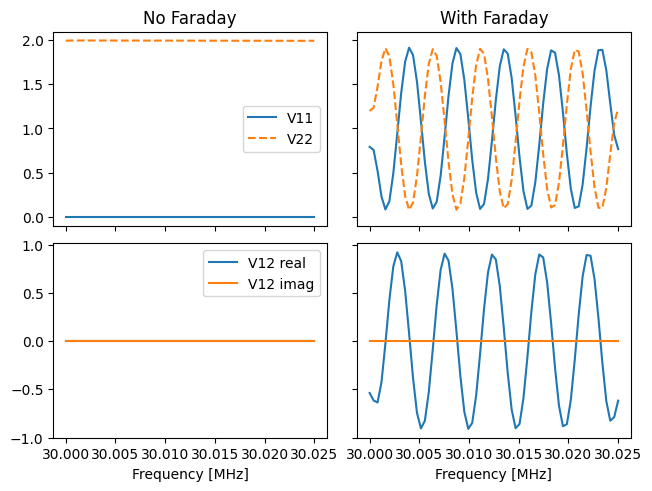

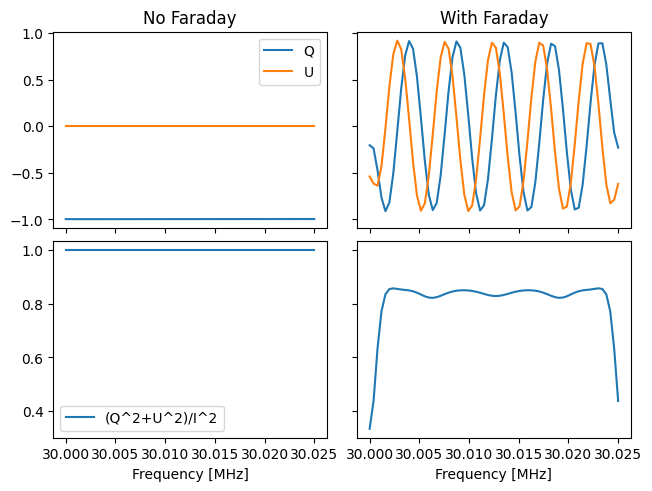

In [8]:
sim = vis_sim.Simulator(freqs, I, Q, U, RM, beam, spec=zoom8[:, 1:], **kwargs)
vis8 = sim.vis(faraday=False, use_spec=USE_SPEC)
vis8_rot = sim.vis(faraday=True, use_spec=USE_SPEC)
if not USE_SPEC:
    vis_sim.plot_vis(freqs/1e6, vis8, vis8_rot)
    vis_sim.plot_stokes(freqs/1e6, vis_sim.vis2stokes(vis8), vis_sim.vis2stokes(vis8_rot))
    
else:
    vis_sim.plot_vis(chans/1e6, vis8, vis8_rot)
    vis_sim.plot_stokes(chans/1e6, vis_sim.vis2stokes(vis8), vis_sim.vis2stokes(vis8_rot))

### 25 kHz bins

In [14]:
# # align spectrometer reponse and simulated frequencies
# from scipy.interpolate import interp1d
# chans = np.arange(nchans) * diff + fmin  # output freqs after spectrometer dot product
# res_factor = 100  # factor to increase reoslution by
# freqs = np.arange(-2*res_factor, (nchans+1)*res_factor+1) * (diff/res_factor) #+ fmin
# #freqs = np.linspace(chans.min(), chans.max(), (chans.size-1)*res_factor+1) # simulation frequencies
# off = freqs[:(4*res_factor+1)] - freqs[2*res_factor]  # interpolation freqs for spec response
# spec4 = interp1d(offset, zoom4[:, 0], kind="cubic", assume_sorted=True)(off)
# spec8 = interp1d(offset, zoom8[:, 0], kind="cubic", assume_sorted=True)(off)
# freqs += fmin

In [21]:
from scipy.interpolate import interp1d
res_factor = 100
off, freqs = vis_sim.interp_freqs(nchans, diff, fmin, res_factor=res_factor)
spec4 = interp1d(offset, zoom4[:, 0], kind="cubic", assume_sorted=True)(off)
spec8 = interp1d(offset, zoom8[:, 0], kind="cubic", assume_sorted=True)(off)


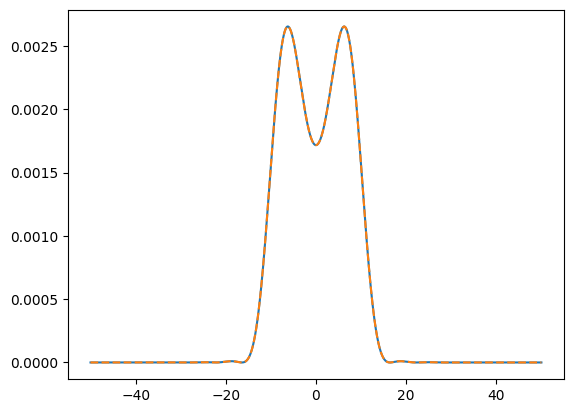

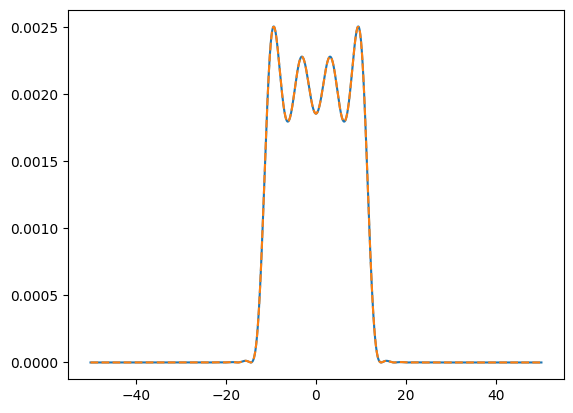

In [22]:
plt.figure()
plt.plot(offset/1e3, zoom4[:, 0])
plt.plot(off/1e3, spec4, ls="--")
plt.show()

plt.figure()
plt.plot(offset/1e3, zoom8[:, 0])
plt.plot(off/1e3, spec8, ls="--")
plt.show()

In [29]:
class FatSimulator(vis_sim.Simulator):
    
    def vis(self, output_chans, faraday=True, use_spec=True):
        ein = "ap, bp, ab...p, p"  # a,b : E_theta/E_phi, p : pixel axis, ... : frequency axis/axes
        norm = 2 / np.sum(np.abs(self.beam1)**2 * self.dOmega)
        if faraday:
            coherency_mat = self.T_rot
        else:
            coherency_mat = self.T
        V11 = np.einsum(ein, self.beam1, self.beam1.conj(), coherency_mat, self.dOmega)
        V22 = np.einsum(ein, self.beam2, self.beam2.conj(), coherency_mat, self.dOmega)
        V12 = np.einsum(ein, self.beam1, self.beam2.conj(), coherency_mat, self.dOmega)
        v_arr = np.real([V11, V12.real, V12.imag, V22]) * norm
        if use_spec:
            # make a spectrometer reponse matrix for each output chan
            spec_mat = np.zeros((output_chans.size, self.freqs.size))
            for i in range(output_chans.size):
                start = i * res_factor
                end = start + self.spec.size
                spec_mat[i, start:end] = self.spec
            v_arr = np.sum(v_arr[:, :, None] * spec_mat.T[None], axis=1)
        return v_arr, spec_mat

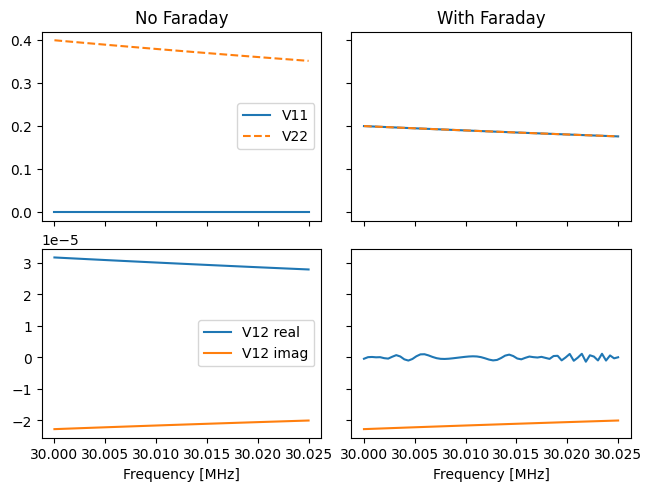

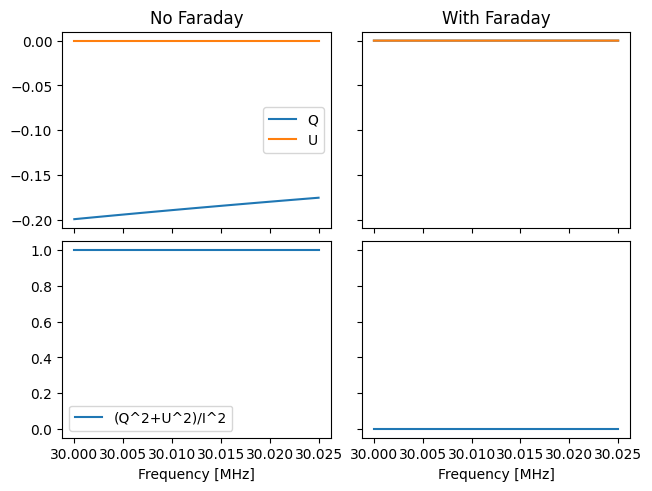

In [41]:
sim = FatSimulator(freqs, I, Q, U, RM, beam, spec=spec4, **kwargs)
vis_arr, spec_mat = sim.vis(chans, faraday=False)
vis_arr_rot = sim.vis(chans, faraday=True)[0]
vis_sim.plot_vis(chans/1e6, vis_arr, vis_arr_rot)
vis_sim.plot_stokes(chans/1e6, vis_sim.vis2stokes(vis_arr), vis_sim.vis2stokes(vis_arr_rot))

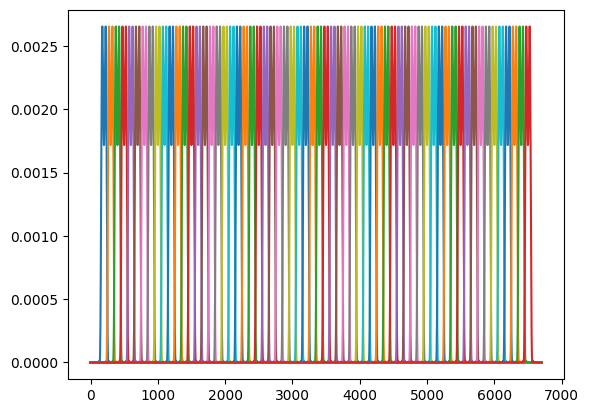

In [40]:
plt.figure()
plt.plot(spec_mat.T)
plt.show()

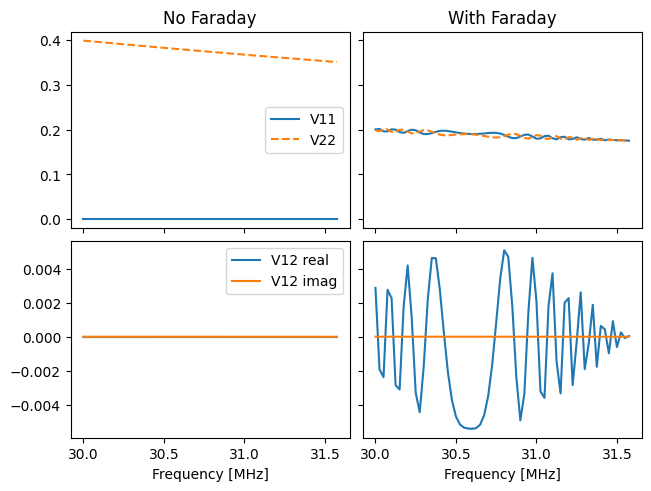

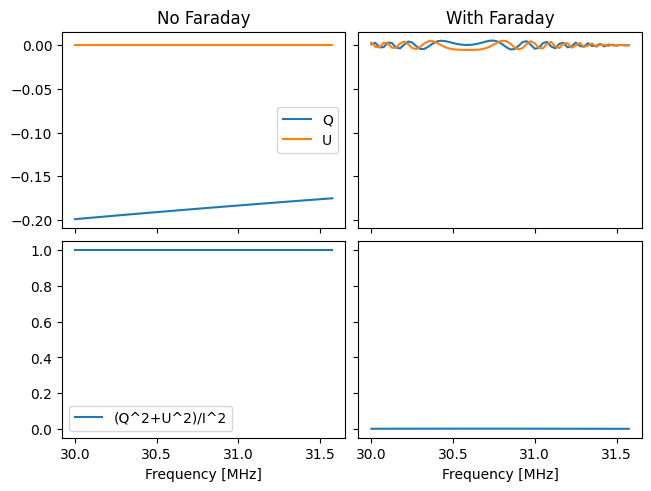

In [37]:
sim = FatSimulator(freqs, I, Q, U, RM, beam, spec=spec8, **kwargs)
vis_arr = sim.vis(chans, faraday=False)
vis_arr_rot = sim.vis(chans, faraday=True)
plot_vis(chans/1e6, vis_arr, vis_arr_rot)
plot_stokes(chans/1e6, vis2stokes(vis_arr), vis2stokes(vis_arr_rot))

## LuSEE Beam

In [9]:
fname = "hfss_lbl_3m_75deg.2port.fits"
#fname = "feko_bnl_3m_75deg.2port.fits"
BEAM_FREQ = 30  # MHz
with fits.open("data/"+fname) as hdul:
    freq_ix = np.argwhere(hdul["freq"].data == BEAM_FREQ)[0, 0]
    E_theta = hdul["Etheta_real"].data + 1j * hdul["Etheta_imag"].data
    E_phi = hdul["Ephi_real"].data + 1j * hdul["Ephi_imag"].data
        
    E_theta = E_theta[freq_ix, :, :-1]
    E_phi = E_phi[freq_ix, :, :-1]
        
    # rotate by 90 since sims are along Y
    E_theta = np.roll(E_theta, -90, axis=-1)
    E_phi = np.roll(E_phi, -90, axis=-1)

short_X = np.array([E_theta, E_phi])
short_Y = np.roll(short_X, 90, axis=-1)

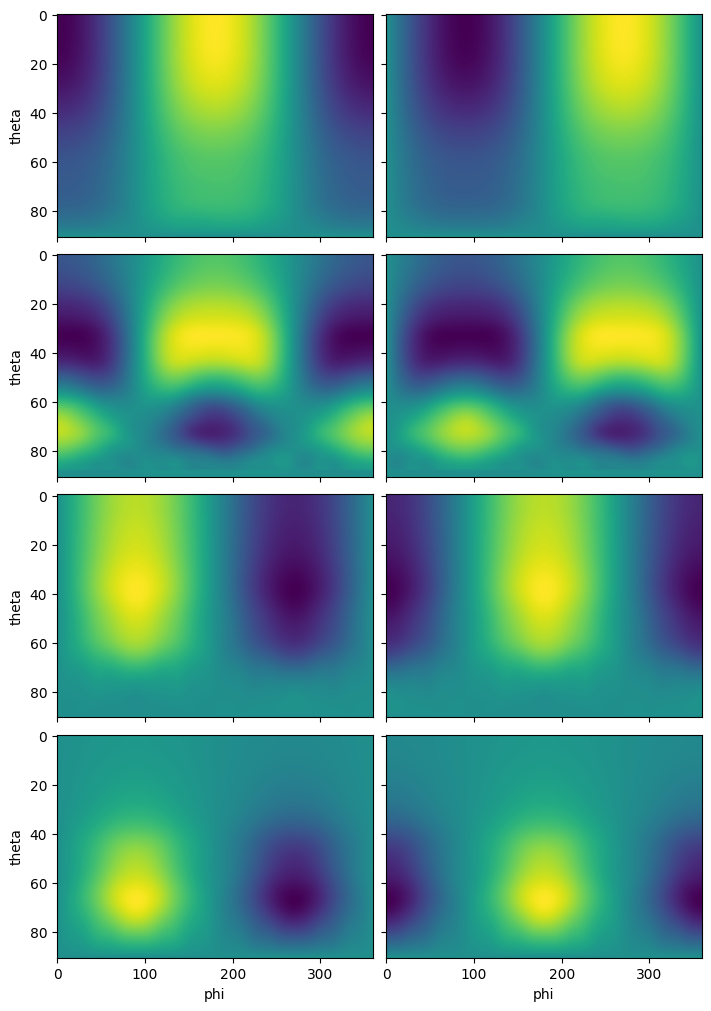

In [10]:
beam1 = np.array([E_theta, E_phi])
beam2 = np.roll(beam1, 90, axis=-1)

fig, axs = plt.subplots(figsize=(7, 10), nrows=4, ncols=2, sharex=True, sharey=True, layout="constrained")
for i in range(2):
    b1 = beam1[i]
    b2 = beam2[i]
    axs[2*i, 0].imshow(b1.real, aspect="auto")
    axs[2*i, 1].imshow(b2.real, aspect="auto")
    axs[2*i+1, 0].imshow(b1.imag, aspect="auto")
    axs[2*i+1, 1].imshow(b2.imag, aspect="auto")
plt.setp(axs[:, 0], ylabel="theta")
plt.setp(axs[-1], xlabel="phi")
plt.show()

# only need beam where src is != 0
beam1 = beam1[:, T <= T_MAX]
beam2 = beam2[:, T <= T_MAX]
beam = np.array([beam1, beam2])

### Zoomed-in region (400 Hz bins)

In [11]:
USE_SPEC = True
sim = vis_sim.Simulator(freqs, I, Q, U, RM, beam, spec=zoom4[:, 1:], **kwargs)
vis4 = sim.vis(faraday=False, use_spec=USE_SPEC)
vis4_rot = sim.vis(faraday=True, use_spec=USE_SPEC)

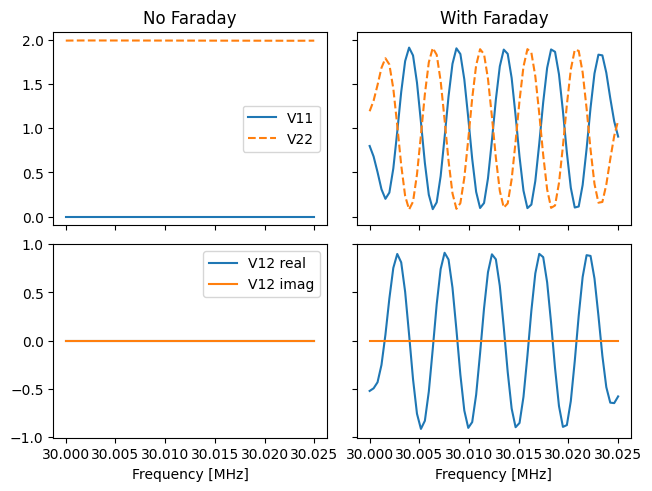

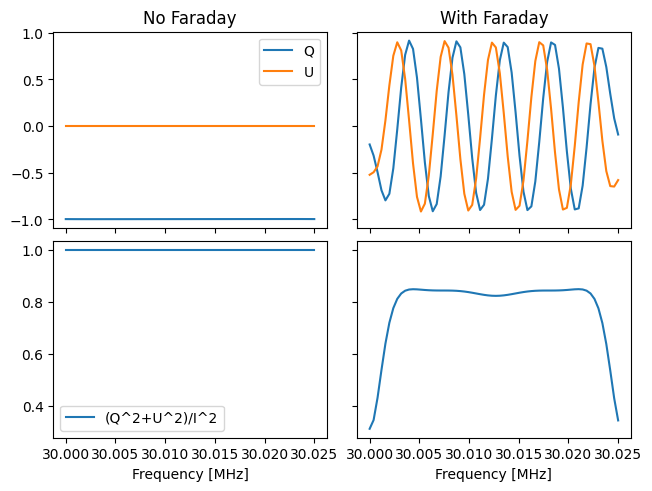

In [12]:
if not USE_SPEC:
    vis_sim.plot_vis(freqs/1e6, vis4, vis4_rot)
    vis_sim.plot_stokes(freqs/1e6, vis_sim.vis2stokes(vis4), vis_sim.vis2stokes(vis4_rot))
    
else:
    vis_sim.plot_vis(chans/1e6, vis4, vis4_rot)
    vis_sim.plot_stokes(chans/1e6, vis_sim.vis2stokes(vis4), vis_sim.vis2stokes(vis4_rot))

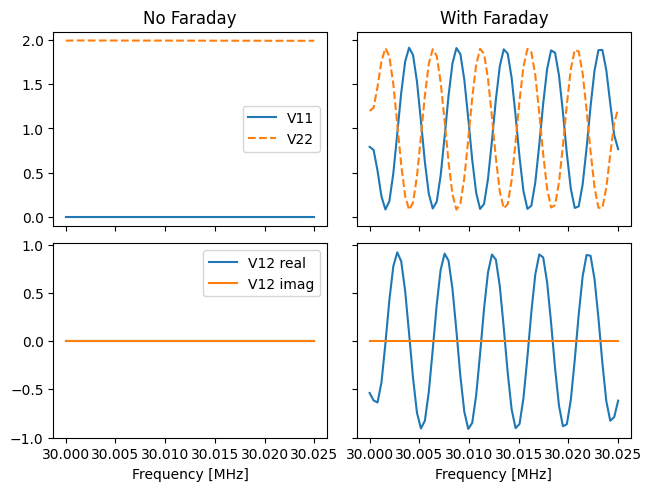

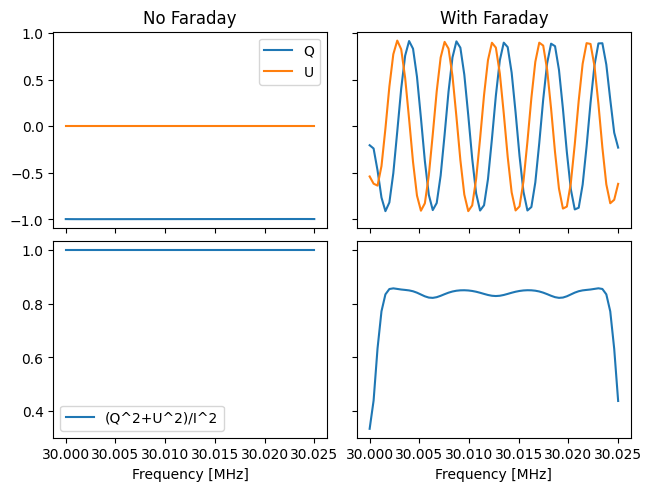

In [13]:
sim = vis_sim.Simulator(freqs, I, Q, U, RM, beam, spec=zoom8[:, 1:], **kwargs)
vis8 = sim.vis(faraday=False, use_spec=USE_SPEC)
vis8_rot = sim.vis(faraday=True, use_spec=USE_SPEC)
if not USE_SPEC:
    vis_sim.plot_vis(freqs/1e6, vis8, vis8_rot)
    vis_sim.plot_stokes(freqs/1e6, vis_sim.vis2stokes(vis8), vis_sim.vis2stokes(vis8_rot))
    
else:
    vis_sim.plot_vis(chans/1e6, vis8, vis8_rot)
    vis_sim.plot_stokes(chans/1e6, vis_sim.vis2stokes(vis8), vis_sim.vis2stokes(vis8_rot))